In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
%matplotlib inline

In [105]:
import cifar10_input
sess = tf.InteractiveSession()
for i in range(100):
    print (i)
    images, labels = sess.run(cifar10_input.distorted_inputs(batch_size=100))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


E0501 11:10:48.227800 140737270424512 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.

E0501 11:10:48.265864 140737270424512 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1334, in _do_call
    return fn(*args)
  File "/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1319, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1407, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: /Users/senqicao/tensorflow_datasets/cifar10/1.0.2/cifar10-train.tfrecord-00003-of-00010; Too many open files
	 [[{{node IteratorGetNext_20}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sen

TypeError: can only concatenate str (not "list") to str

W0430 16:17:17.331994 140737270424512 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


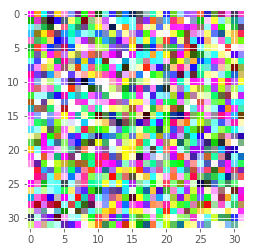

In [4]:
im = np.random.normal(0,1,[32*32*3])
im = np.reshape(np.abs(im) ,[32,32,3])
plt.imshow(im)
plt.show()
safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])

In [254]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])

M = 100
D=4*4*512
h1=1024
D2=10

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def pad3D(c_x, padlen=1):
    batch,m,n,r = c_x.shape
    c_y = np.zeros((batch,m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[:, padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    x = np.random.randint(0, img.shape[2] - width)
    y = np.random.randint(0, img.shape[1] - height)
    img = img[:,y:y+height, x:x+width,:]
    return img

def stand(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im)
    std = np.std(im)
    std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
    im = (im-mean)/std1
    return im

def preprocess(x_batch):
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = np.fliplr(x_batch)
    x_batch = stand(x_batch)
    return x_batch

tf.reset_default_graph()
# variables
with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
    Y = tf.placeholder(tf.float32, [None,])
    b = tf.placeholder(tf.bool,shape=(),name='b')
    learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

    w_conv1 = tf.get_variable('w_conv1', [3,3,3,128], initializer = tf.contrib.layers.xavier_initializer())
    w_conv2 = tf.get_variable('w_conv2', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())
    w_conv3 = tf.get_variable('w_conv3', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
    w_conv4 = tf.get_variable('w_conv4', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
    w_conv5 = tf.get_variable('w_conv5', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
    w_conv6 = tf.get_variable('w_conv6', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

    w0 = tf.get_variable('w_fc1', [4*4*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
    b0 = tf.get_variable('b_fc1', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
    w1 = tf.get_variable('w_fc2', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

    # network
    #b=True
    con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)

    con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
    h_pool2 = max_pool_2x2(h_conv2)

    con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
    h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=b)

    con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
    h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=b)
    h_pool4 = max_pool_2x2(h_conv4)

    con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
    h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

    con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
    h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    h_pool6 = max_pool_2x2(h_conv6)

    h_pool_flat = tf.layers.flatten(h_pool6)

    h = tf.nn.relu(tf.matmul(h_pool_flat, w0) + b0)
    logits = tf.matmul(h, w1) + b1
    output = tf.nn.softmax(logits)#batch*10

    #evaluation
    probs = tf.reduce_sum(output*Y,1)#batch*1
    p=tf.reduce_mean(probs,0)#积分
    cross_ent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.cast(Y, tf.int64)))
    regularization = 1e-4*(tf.reduce_sum(tf.square(w0))+tf.reduce_sum(tf.square(b0))+tf.reduce_sum(tf.square(w1))+tf.reduce_sum(tf.square(b1)))
    loss = cross_ent + regularization
    max_p = tf.reduce_max(output,1)
    ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)

    #correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
    #tmp = tf.cast(tf.argmax(output,1), tf.float32)
    correct_pred = tf.equal(tf.argmax(output,1), tf.cast(Y, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # training
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    saver = tf.train.Saver(max_to_keep = 200)
    
config = tf.ConfigProto(allow_soft_placement = True)
with tf.Session(config = config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_point_estimation/classification_mnist60/model.ckpt")
    for i in range(90000):
        #print("time",i,time.time() - start_time, file=open("prints.txt", "a")) 
        print("time",i,time.time() - start_time) 
        start_time1 = time.time()
        seed = np.random.randint(0,50000,100)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = preprocess(x_batch)
        print('preprocessing:',time.time() - start_time1)
        #x_batch = sess.run(tf.cast(x_batch, tf.float32))
        #x_batch = sess.run(tf.random_crop(x_batch, [100, 32, 32, 3]))
        #x_batch = sess.run(tf.image.random_flip_left_right(x_batch))
        #x_batch = sess.run(tf.image.per_image_standardization(x_batch))

        if i%100==0 and i!=0:
            maxp_OOD = []
            ent_OOD = []
            test_accuracy = []
            maxp_in = []
            ent_in = []                       
            for j in range(0,100):
                #start_time = time.time()
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                imgs_in = sess.run(tf.image.per_image_standardization(imgs_in))
                #print('preprocessing:',time.time() - start_time)

                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,32,32,3]),Y:labels_in,b:False})
                #maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                #ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                test_accuracy.append(acc)
                #maxp_in.extend(maxp_in1)
                #ent_in.extend(ent_in1)
                
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(np.array(test_accuracy))
            #maxp_in = np.array(maxp_in)
            #ent_in = np.array(ent_in)
            #test_error = np.mean(np.array(test_accuracy))
            print("test:",test_accuracy)
            '''
            safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])
            for k in range(0,92):
                imgs_OOD = safe_images[k*100:(k+1)*100]
                maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                maxp_OOD.extend(maxp_OOD1)
                ent_OOD.extend(ent_OOD1)
            maxp_OOD = np.array(maxp_OOD)
            ent_OOD = np.array(ent_OOD)
            

            #validation_error = sess.run(accuracy, {X:np.reshape(validation_x,[1000,28,28,1]), Y:validation_y,b:False})
            test_error = np.mean(np.array(test_accuracy))
            print ("time:",i, time.time() - start_time, "test accuracy", test_error)
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
            
            safe, risky  = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            '''
        
        if i < 5000:
            a = 0.01
        elif i < 10000:
            a = 0.005
        elif i < 20000:
            a = 0.001
        elif i < 50000:
            a = 0.0005
        elif i < 80000:
            a = 0.0001
        else:
            a = 0.00005
        
        sess.run(train_step,{X: x_batch, Y: y_batch,learning_rate:a, b:True})
        
        if i%500==0:
            save_path = saver.save(sess, "./cifar10_point_estimation/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

time 0 1.0124363899230957
preprocessing: 0.004923105239868164
time 1 8.418987035751343
preprocessing: 0.006891012191772461
time 2 14.57830023765564
preprocessing: 0.0030431747436523438
time 3 20.581504106521606
preprocessing: 0.0032389163970947266
time 4 26.5666081905365
preprocessing: 0.003362894058227539
time 5 32.38894534111023
preprocessing: 0.0026540756225585938
time 6 38.185102224349976
preprocessing: 0.0031921863555908203
time 7 44.087196350097656
preprocessing: 0.0031709671020507812
time 8 50.016112327575684
preprocessing: 0.003209829330444336
time 9 55.91286516189575
preprocessing: 0.005452156066894531
time 10 61.81848907470703
preprocessing: 0.003214120864868164
time 11 67.70462322235107
preprocessing: 0.003058910369873047
time 12 73.69991827011108
preprocessing: 0.003047943115234375
time 13 79.59760999679565
preprocessing: 0.0032100677490234375
time 14 85.4794282913208
preprocessing: 0.003097057342529297
time 15 91.34702730178833
preprocessing: 0.002991199493408203
time 16 9

KeyboardInterrupt: 

In [240]:
x_batch = x_train[1]

In [241]:
def pad3D(c_x, padlen=1):
    m,n,r = c_x.shape
    c_y = np.zeros((m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    x = np.random.randint(0, img.shape[1] - width)
    y = np.random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    return img

def stand(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im)
    std = np.std(im)
    std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
    im = (im-mean)/std1
    return im
def preprocess(x_batch):
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = np.fliplr(x_batch)
    x_batch = stand(x_batch)
    return x_batch

In [242]:
x_batch = preprocess(x_batch)

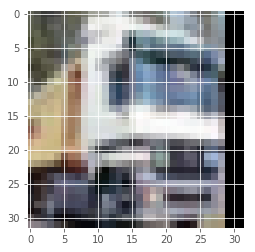

In [243]:
plt.imshow(x_batch)
plt.show()

In [85]:
x_batch.shape

(36, 36, 7)

In [3]:
# Creates a graph.
with tf.device('/cpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


In [77]:
x_batch.shape

(100, 32, 32, 3)

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

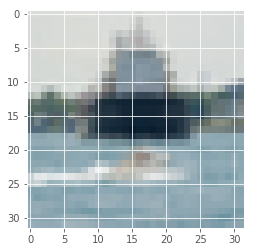

In [10]:
seed = np.random.randint(0,50000,100)
x_batch = x_train[seed]
x_batch = x_batch
plt.imshow(x_batch[1])
plt.show()

In [20]:
sess = tf.InteractiveSession()

/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
x_batch = sess.run(tf.cast(x_batch, tf.float32))

In [30]:
x_batch.shape

(100, 32, 32, 3)

In [29]:
x_batch = sess.run(tf.image.per_image_standardization(x_batch))

In [26]:
x_batch = sess.run(tf.cast(x_batch, tf.float32))
#x_batch = sess.run(tf.random_crop(x_batch, [32, 32, 3]))
x_batch = sess.run(tf.image.random_flip_left_right(x_batch))
#x_batch = sess.run(tf.image.random_brightness(x_batch, max_delta=0.5))
#x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
x_batch = sess.run(tf.image.per_image_standardization(x_batch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


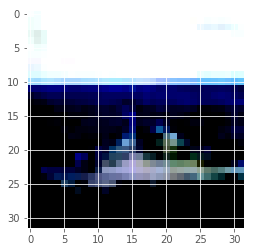

In [27]:
#x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
plt.imshow(x_batch[1])
plt.show()

In [81]:
x_batch.shape

(100, 32, 32, 3)

In [34]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.eager import context

def cyclic_learning_rate(global_step,
                         learning_rate=0.01,
                         max_lr=0.1,
                         step_size=20.,
                         gamma=0.99994,
                         mode='triangular',
                         name=None):
  """Applies cyclic learning rate (CLR).
     From the paper:
     Smith, Leslie N. "Cyclical learning
     rates for training neural networks." 2017.
     [https://arxiv.org/pdf/1506.01186.pdf]
      This method lets the learning rate cyclically
     vary between reasonable boundary values
     achieving improved classification accuracy and
     often in fewer iterations.
      This code varies the learning rate linearly between the
     minimum (learning_rate) and the maximum (max_lr).
      It returns the cyclic learning rate. It is computed as:
       ```python
       cycle = floor( 1 + global_step /
        ( 2 * step_size ) )
      x = abs( global_step / step_size – 2 * cycle + 1 )
      clr = learning_rate +
        ( max_lr – learning_rate ) * max( 0 , 1 - x )
       ```
      Polices:
        'triangular':
          Default, linearly increasing then linearly decreasing the
          learning rate at each cycle.
         'triangular2':
          The same as the triangular policy except the learning
          rate difference is cut in half at the end of each cycle.
          This means the learning rate difference drops after each cycle.
         'exp_range':
          The learning rate varies between the minimum and maximum
          boundaries and each boundary value declines by an exponential
          factor of: gamma^global_step.
       Example: 'triangular2' mode cyclic learning rate.
        '''python
        ...
        global_step = tf.Variable(0, trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate=
          clr.cyclic_learning_rate(global_step=global_step, mode='triangular2'))
        train_op = optimizer.minimize(loss_op, global_step=global_step)
        ...
         with tf.Session() as sess:
            sess.run(init)
            for step in range(1, num_steps+1):
              assign_op = global_step.assign(step)
              sess.run(assign_op)
        ...
         '''
       Args:
        global_step: A scalar `int32` or `int64` `Tensor` or a Python number.
          Global step to use for the cyclic computation.  Must not be negative.
        learning_rate: A scalar `float32` or `float64` `Tensor` or a
        Python number.  The initial learning rate which is the lower bound
          of the cycle (default = 0.1).
        max_lr:  A scalar. The maximum learning rate boundary.
        step_size: A scalar. The number of iterations in half a cycle.
          The paper suggests step_size = 2-8 x training iterations in epoch.
        gamma: constant in 'exp_range' mode:
          gamma**(global_step)
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
        name: String.  Optional name of the operation.  Defaults to
          'CyclicLearningRate'.
       Returns:
        A scalar `Tensor` of the same type as `learning_rate`.  The cyclic
        learning rate.
      Raises:
        ValueError: if `global_step` is not supplied.
      @compatibility(eager)
      When eager execution is enabled, this function returns
      a function which in turn returns the decayed learning
      rate Tensor. This can be useful for changing the learning
      rate value across different invocations of optimizer functions.
      @end_compatibility
  """
  if global_step is None:
    raise ValueError("global_step is required for cyclic_learning_rate.")
  with ops.name_scope(name, "CyclicLearningRate",
                      [learning_rate, global_step]) as name:
    learning_rate = ops.convert_to_tensor(learning_rate, name="learning_rate")
    dtype = learning_rate.dtype
    global_step = math_ops.cast(global_step, dtype)
    step_size = math_ops.cast(step_size, dtype)
    def cyclic_lr():
      """Helper to recompute learning rate; most helpful in eager-mode."""
      # computing: cycle = floor( 1 + global_step / ( 2 * step_size ) )
      double_step = math_ops.multiply(2., step_size)
      global_div_double_step = math_ops.divide(global_step, double_step)
      cycle = math_ops.floor(math_ops.add(1., global_div_double_step))
      # computing: x = abs( global_step / step_size – 2 * cycle + 1 )
      double_cycle = math_ops.multiply(2., cycle)
      global_div_step = math_ops.divide(global_step, step_size)
      tmp = math_ops.subtract(global_div_step, double_cycle)
      x = math_ops.abs(math_ops.add(1., tmp))
      # computing: clr = learning_rate + ( max_lr – learning_rate ) * max( 0, 1 - x )
      a1 = math_ops.maximum(0., math_ops.subtract(1., x))
      a2 = math_ops.subtract(max_lr, learning_rate)
      clr = math_ops.multiply(a1, a2)
      if mode == 'triangular2':
        clr = math_ops.divide(clr, math_ops.cast(math_ops.pow(2, math_ops.cast(
            cycle-1, tf.int32)), tf.float32))
      if mode == 'exp_range':
        clr = math_ops.multiply(math_ops.pow(gamma, global_step), clr)
      return math_ops.add(clr, learning_rate, name=name)
    if not context.executing_eagerly():
      cyclic_lr = cyclic_lr()
    return cyclic_lr